# Implementation of MCMC algorithm from Chib 1996

**Reference:** Chib. S. (1996), "Calculating Posterior Distributions and Modal Estimates in Markov Mixture Models", _Journal of Econometrics_, 75, 79-97.  

## The generative model

I plan on simulating data similar to the _Poisson fetal data_ reported in section 4.1 of the paper.

The code below simply is a header for the Python code to come.

In [86]:
#from __future__ import print_function # for compatibility with Python 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rv_discrete, beta
from scipy import stats
import scipy

We consider a HMM where 
$$s_t\in\{1,2\}$$
is a _hidden_ state variable controlling the rate 
$$\lambda_{s_t}\in \{\lambda_1,\lambda_2\}$$
of a Poisson random variable 
$$y_t$$
which is _observed_ on N=240 consecutive 5-second intervals.

The hidden process is a Markov Chain evolving according to the transition matrix
$$P$$

Select the two rates `lambda1`, `lambda2` (Hz), the hazard rate `h` (in [0,1]) of the hidden chain, and the total number `N` of observations, for generating simulated data (the sliders and boxes next to them are _interactive!_).

In [87]:
def f(lambda1=1.0, lambda2=2.0, h=.1000, N=240):
    return np.array([lambda1, lambda2, h, N])
w = interactive(f, lambda1=(0.0,20.0), lambda2=(0.0,20.0), h=(0.0,1.0,0.001),N=(100,1000))
display(w)

We produce the observations here

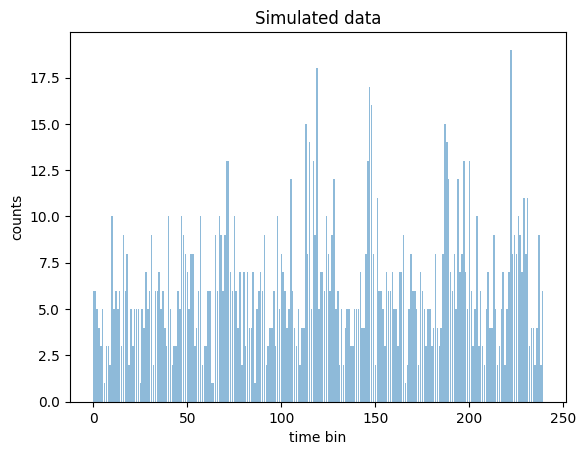

In [88]:
lambda1, lambda2, h, N = w.result
N = int(N)
states = np.array([lambda1, lambda2])
time = np.arange(N) + 1
y_pos = np.arange(len(time))
counts = np.zeros(len(time))

# function that switches the environment state that is given as argument
def switch(rate):
    try:
        if rate in states:
            if rate == states[0]:
                return states[1]
            else:
                return states[0]
        else:
            raise ValueError("Error in argument 'rate': must be an element of "
                             "'states'")
    except ValueError as err:
        print(err.args)

last_state = states[0]  # Force environment in state 1 at time 1
for t in np.arange(N):
    draw = np.random.uniform()
    if t == 0 or (draw > h):
        new_state = last_state
    else:
        new_state = switch(last_state)
        
    counts[t] = np.random.poisson(5*new_state) 
    last_state = new_state

# plt.figure(1)
plt.bar(y_pos, counts, align='center', alpha=0.5)
# plt.xticks(y_pos, time)
plt.xlabel('time bin')
plt.ylabel('counts')
plt.title('Simulated data')

plt.show()

We now need to simulate the joint posterior over the state using
$$p(S_n|Y_n,\theta)=p(s_n|Y_n,\theta)\times\cdots\times p(s_t|Y_n,S^{t+1},\theta)\times \cdots\times p(s_1|Y_n,S^2,\theta)$$

To sample from the LHS, it is enough to sample sequentially from each term on the RHS.
The typical RHS term is 
$$p(s_t|Y_n,S^{t+1},\theta)\propto p(s_t|Y_t,\theta)\times p(s_{t+1}|s_t,\theta)$$


Furthermore, once we know $$p(s_{t-1}|Y_{t-1}.\theta)$$ the _prediction step_ yields,
$$p(s_t|Y_{t-1},\theta)=\sum_{k=1}^2 p(s_t|s_{t-1}=k,\theta)\times p(s_{t-1}=k|Y_{t-1},\theta)$$
and the _update step_:
$$p(s_t|Y_t,\theta)\propto p(s_t|Y_{t-1},\theta)\times f(y_t|Y_{t-1},\theta_{s_t})$$

In all the equations above, theta stands for the unknown hazard rate h, which, at this stage, must be sampled from a Beta prior. Choose below your Beta prior hyperparameters a and b:

In [107]:
def g(a=1.0, b=1.0):
    return np.array([a, b])
ww = interactive(g, a=(1,40), b=(1,40))
display(ww)

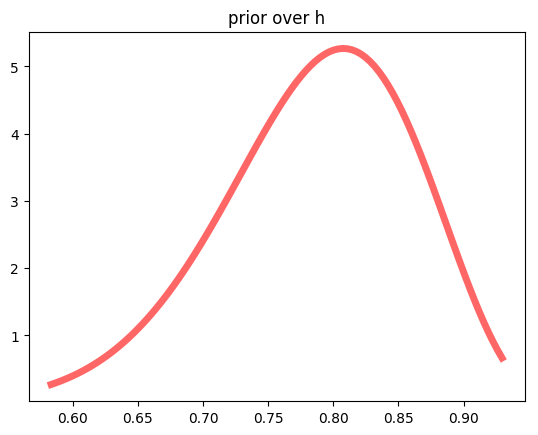

In [111]:
a, b = ww.result
plt.figure(3)
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')
plt.title('prior over h')
plt.show()

The following is just a class to handily compute Poisson pdfs

In [91]:
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_discrete.html
class poisson_gen(rv_discrete):
    "Poisson distribution"
    def _pmf(self, k, mu):
        return np.exp(-mu) * mu**k / scipy.misc.factorial(k)

In [92]:
poisson = poisson_gen(name="poisson")

In [93]:
print(poisson._pmf(1,1))

0.367879441171


We initialize with the stationary distribution

In [94]:
xk = np.array([1,2])
pk = np.array([0.5,0.5])
curr_post = stats.rv_discrete(name='curr_post', values=(xk, pk))

In [95]:
S = np.zeros(N)

In [96]:
S[0] = curr_post.rvs()

In [97]:
unnorm = np.zeros(2)

In [98]:
def rate_fcn(state):
    if state == 1:
        return lambda1
    else:
        return lambda2
        

In [99]:
unnorm[0]=curr_post.pmf(1)*poisson._pmf(counts[0],rate_fcn(1))
unnorm[1]=curr_post.pmf(2)*poisson._pmf(counts[0],rate_fcn(2))
print(unnorm)
print(unnorm.sum())

[ 0.00025547  0.0060149 ]
0.00627037331133


In [100]:
pk = np.divide(unnorm, unnorm.sum())
print(pk)
curr_post = stats.rv_discrete(name='curr_post', values=(xk, pk))

[ 0.04074268  0.95925732]


In [101]:
S[1] = curr_post.rvs()

In [102]:
print(S[0:2])

[ 2.  2.]
